# Problem 2
## Convoluted Autoencoders - 4 Architectures

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

#### Function to flip the values

In [6]:
def flip(x):
    x_flip = x.copy()
    for i in range(len(x)):
        x_1d = x[i].flatten()
        flip_indices = np.random.choice(len(x_1d),int(0.03*len(x_1d)))
        x_1d[flip_indices] = 255 - x_1d[flip_indices]
        x_flip[i] = x_1d.reshape(28,28)
    return x_flip

x_train_120 = np.tile(x_train,(2,1,1))
x_train_flip = flip(x_train_120)
x_test_flip = flip(x_test)

#### Normalizing and reshaping 

In [7]:
x_train_120 = x_train_120.astype('float32') / 255.
x_train_flip = x_train_flip.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_test_flip = x_test_flip.astype('float32') / 255.

x_train_120 = np.reshape(x_train_120, (len(x_train_120), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_train_flip = np.reshape(x_train_flip, (len(x_train_flip), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test_flip = np.reshape(x_test_flip, (len(x_test_flip), 28, 28, 1))  # adapt this if using `channels_first` image data format


## CNN Architechture 1

In [45]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse','accuracy'])

#, loss='mean_squared_error'

hist = autoencoder.fit(x_train_flip, x_train_120,
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_flip, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)],verbose=False)

base_dir = os.path.dirname(os.path.realpath(__file__))
model_file = os.path.join(base_dir, 'cnn1_model.h5')
autoencoder.save(model_file)

val_mse = hist.history['val_mean_squared_error']

with open('cnn1_mse.txt','w')  as fp:
    for vv in val_mse:
        strw = str(vv)+'\n'
        fp.write(strw)

#### Functions to plot MSE and print best and worst digits

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model, load_model
from numpy import linalg as LA
import operator

def plot_mse(loss):
    #plt.figure(figsize=(9,5))
    plt.plot(loss)
    plt.title("Test set Mean Square Error",fontsize=20)
    plt.xlabel("Training epochs")
    plt.ylabel("MSE")
    plt.grid(True)


def best_worst(decoded_imgs):
    error = {}

    for i in range(10000):
        e = LA.norm(x_test_flip[i]-decoded_imgs[i])
        error[i] = e

    sorted_x = sorted(error.items(), key=operator.itemgetter(1))

    best = [key for key,_ in sorted_x[:10]]
    worst = [key for key,_ in sorted_x[-10:]]
    
    return best,worst

def print_digits(case):
    n = 11
    plt.figure(figsize=(20, 4))

    for i in range(1,n):
        # display original

        ax = plt.subplot(2, n, i)
        plt.imshow(x_test_flip[case[i-1]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(decoded_imgs[case[i-1]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Test Set Error 

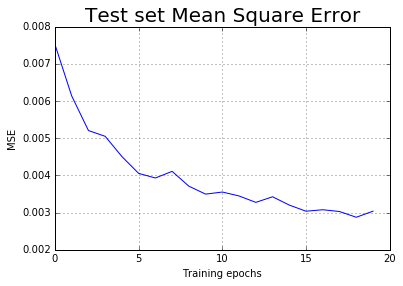

In [9]:
with open('cnn1_mse.txt') as f:
    loss = f.read().splitlines()
plot_mse(loss)    

### Best Set of Digits

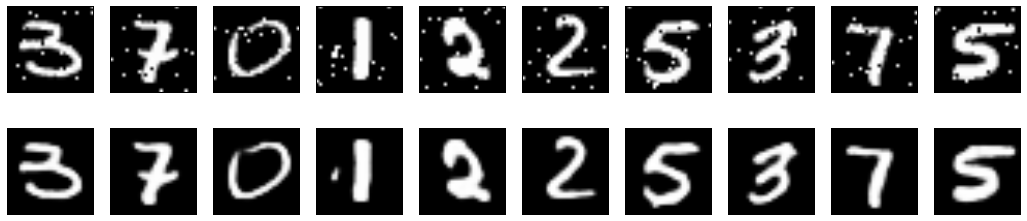

In [10]:
autoencoder_load = load_model('cnn1_model.h5')
decoded_imgs = autoencoder_load.predict(x_test_flip)
best,worst = best_worst(decoded_imgs)
print_digits(best)

### Worst set of digits

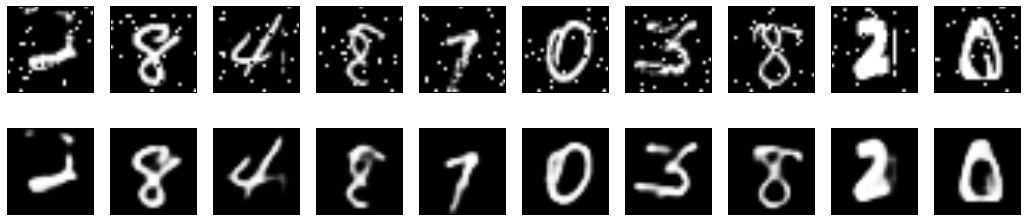

In [11]:
print_digits(worst)

## CNN Architechture 2

This model consists of tanh layers instead of relu and consists of adam optimizer instead of adadelta.

In [71]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='tanh', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='tanh', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse','accuracy'])

#, loss='mean_squared_error'

hist = autoencoder.fit(x_train_flip, x_train_120,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_flip, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)], verbose=True)

base_dir = os.path.dirname(os.path.realpath(__file__))
model_file = os.path.join(base_dir, 'cnn2_model.h5')
autoencoder.save(model_file)

val_mse = hist.history['val_mean_squared_error']

fp = open('cnn2_mse.txt','w')

for vv in val_mse:
    strw = str(vv)+'\n'
    fp.write(strw)

## Test Set Error 

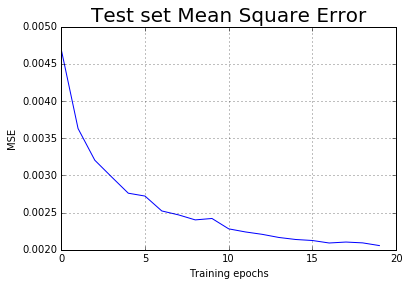

In [75]:
f = open('cnn2_mse.txt','r')
loss = f.read().splitlines()
plot_mse(loss)   

## Best Set of Digits

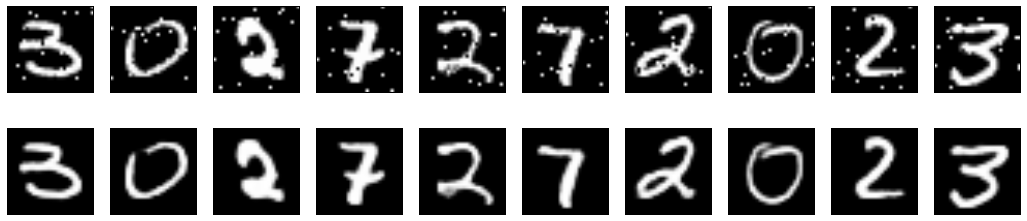

In [12]:
autoencoder_load = load_model('cnn2_model.h5')
decoded_imgs = autoencoder_load.predict(x_test_flip)
best,worst = best_worst(decoded_imgs)
print_digits(best)

## Worst Set of Digits

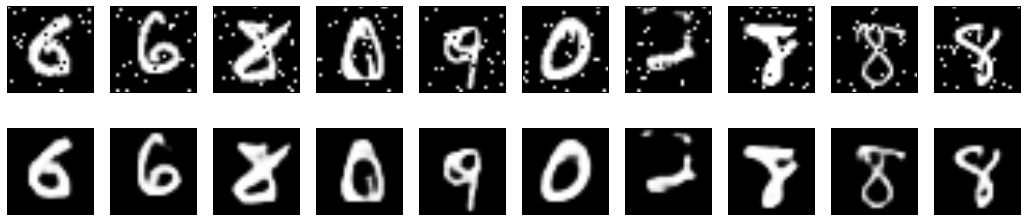

In [13]:
print_digits(worst)

## CNN Architechture 3

This model consists of linear layers instead of relu and consists of adam optimizer instead of adadelta.

In [79]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='linear', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='linear', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='linear', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse','accuracy'])

hist = autoencoder.fit(x_train_flip, x_train_120,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_flip, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)], verbose=True)

base_dir = os.path.dirname(os.path.realpath(__file__))
model_file = os.path.join(base_dir, 'cnn3_model.h5')
autoencoder.save(model_file)

val_mse = hist.history['val_mean_squared_error']

fp = open('cnn3_mse.txt','w')

for vv in val_mse:
    strw = str(vv)+'\n'
    fp.write(strw)

## Test Set Error 

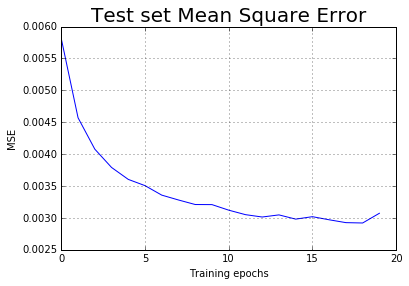

In [80]:
f = open('cnn3_mse.txt','r')
loss = f.read().splitlines()
plot_mse(loss)   

## Best Set of Digits

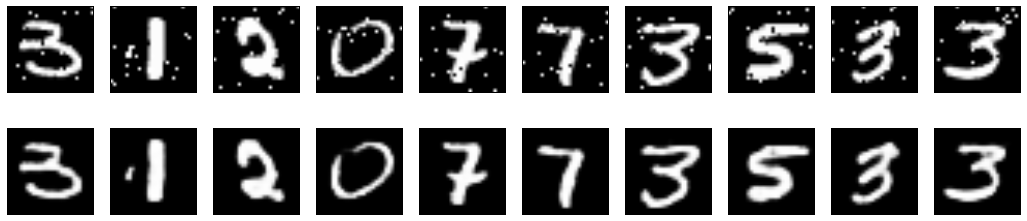

In [14]:
autoencoder_load = load_model('cnn3_model.h5')
decoded_imgs = autoencoder_load.predict(x_test_flip)
best,worst = best_worst(decoded_imgs)
print_digits(best)

## Worst Set of Digits

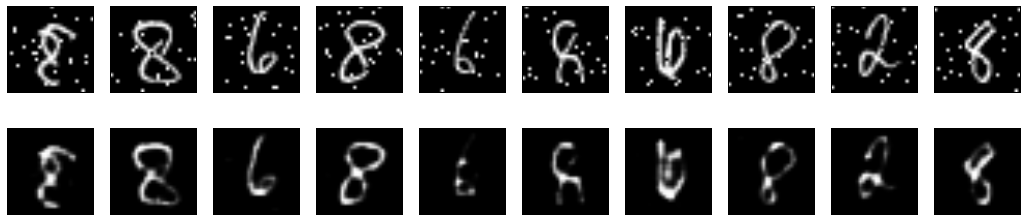

In [15]:
print_digits(worst)

## CNN Architechture 4

This model consists of linear layers instead of relu and consists of adam optimizer instead of adadelta. It also has lesser number of filters (16) compared to 32.

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='linear', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='linear', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(16, (3, 3), activation='linear', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse','accuracy'])

hist = autoencoder.fit(x_train_flip, x_train_120,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_flip, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)], verbose=True)

base_dir = os.path.dirname(os.path.realpath(__file__))
model_file = os.path.join(base_dir, 'cnn4_model.h5')
autoencoder.save(model_file)

val_mse = hist.history['val_mean_squared_error']

fp = open('cnn4_mse.txt','w')

for vv in val_mse:
    strw = str(vv)+'\n'
    fp.write(strw)

## Test Set Error 

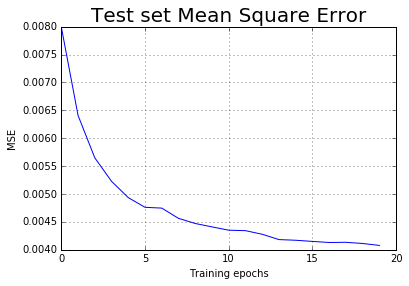

In [83]:
f = open('cnn4_mse.txt','r')
loss = f.read().splitlines()
plot_mse(loss)  

## Best Set of Digits

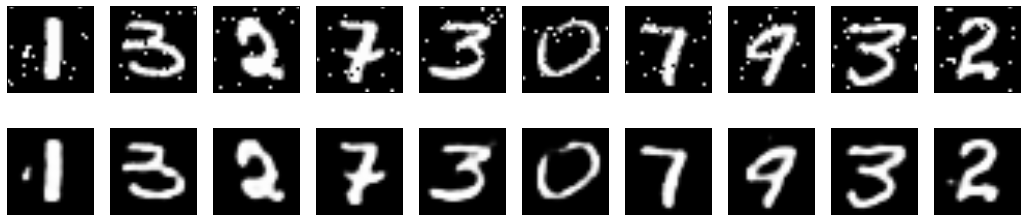

In [16]:
autoencoder_load = load_model('cnn4_model.h5')
decoded_imgs = autoencoder_load.predict(x_test_flip)
best,worst = best_worst(decoded_imgs)
print_digits(best)

## Worst Set of Digits

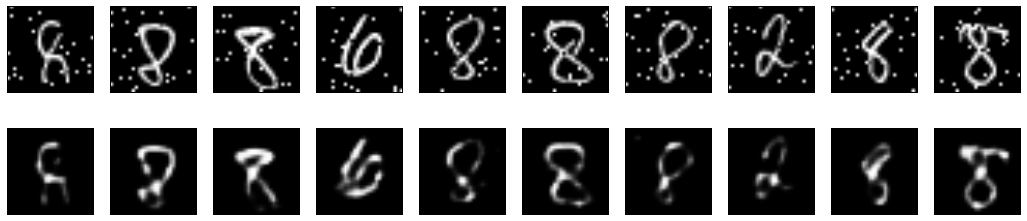

In [17]:
print_digits(worst)